In [1]:
#import the libraries
import psycopg2
import geopandas as gpd
from shapely.geometry import Point, Polygon
#import contextily as cx
#import osmnx as ox
import shapely

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

c:\Users\jesic\anaconda3\envs\osm2\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# PostgreSQL database connection details
db_params = {
    "host": "::1",
    "database": "osm",
    "user": "postgres",
    "password": 
}

In [3]:
#define the query
conn = psycopg2.connect(**db_params)
query_table2 = """
    select * from amenity_counts  
"""

In [4]:
#generate the table from the query
amenity_count = gpd.read_postgis(query_table2, conn, geom_col="point_id")
#observe the dataset
amenity_count.head()
conn.close()

c:\Users\jesic\anaconda3\envs\osm2\lib\site-packages\geopandas\io\sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [5]:
amenity_count_model=amenity_count.copy()
amenity_count_model["food_and_bev"]=amenity_count['amenity_count_restaurant']+amenity_count['amenity_count_cafe']+amenity_count['amenity_count_fast_food']+amenity_count['amenity_count_pub']+amenity_count['amenity_count_bar']
amenity_count_model = amenity_count_model.drop(columns=[ 'amenity_count_restaurant', 'amenity_count_cafe',
       'amenity_count_fast_food', 'amenity_count_pub', 'amenity_count_bar'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(amenity_count_model.drop(columns=["point_id","food_and_bev"]), amenity_count_model["food_and_bev"], test_size = 0.3, random_state = 101)

In [7]:
regr = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 114)
regr.fit(X_train, y_train)

predictions = regr.predict(X_test)

r2 = r2_score(y_test, predictions)
r2

0.8418477981735545

In [8]:
characteristics = X_train.columns
# Get the variables importances, sort them, and print the result
importances = list(regr.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: amenity_count_atm    Importance: 0.73
Variable: amenity_count_pharmacy Importance: 0.06
Variable: amenity_count_ice_cream Importance: 0.04
Variable: amenity_count_bicycle_parking Importance: 0.03
Variable: amenity_count_arts_centre Importance: 0.03
Variable: amenity_count_parking_entrance Importance: 0.01
Variable: amenity_count_charging_station Importance: 0.01
Variable: amenity_count_bank   Importance: 0.01
Variable: amenity_count_place_of_worship Importance: 0.01
Variable: amenity_count_theatre Importance: 0.01
Variable: railway_count_tram_stop Importance: 0.01
Variable: railway_count_stop   Importance: 0.01
Variable: railway_count_subway_entrance Importance: 0.01
Variable: amenity_count_parking Importance: 0.0
Variable: amenity_count_taxi   Importance: 0.0
Variable: amenity_count_post_office Importance: 0.0
Variable: amenity_count_fuel   Importance: 0.0
Variable: amenity_count_nightclub Importance: 0.0
Variable: amenity_count_school Importance: 0.0
Variable: amenity_count

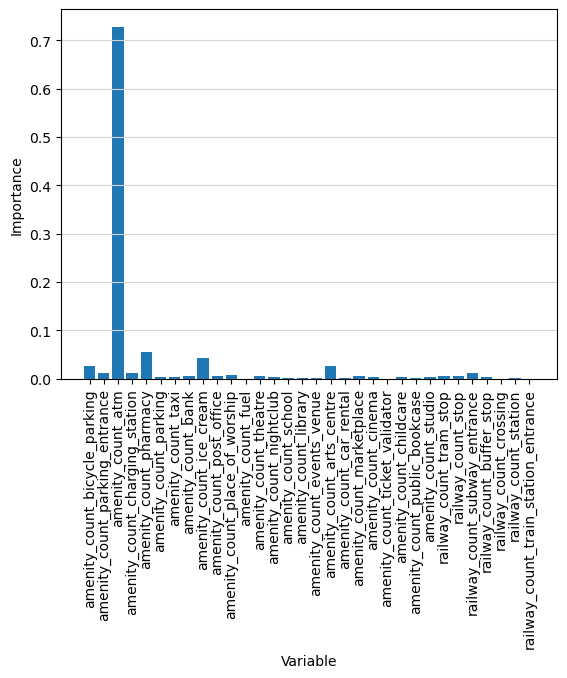

In [9]:
# Visualize the variables importances
plt.bar(characteristics, importances, orientation = 'vertical')
plt.xticks(rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.grid(axis = 'y', color = '#D3D3D3', linestyle = 'solid')
plt.show()

In [10]:
xgbr = XGBRegressor(n_estimators = 100, max_depth = 10, random_state = 114)
xgbr.fit(X_train, y_train)

predictions = xgbr.predict(X_test)

r2 = r2_score(y_test, predictions)
r2

0.8771255750128599

In [11]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.01, .03, .05, ], #so called `eta` value
              'max_depth': [3, 4, 5, 10],
              'min_child_weight': [2, 3, 4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [200, 300, 400]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


c:\Users\jesic\anaconda3\envs\osm2\lib\site-packages\xgboost\core.py:160: UserWarning: [21:51:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
c:\Users\jesic\anaconda3\envs\osm2\lib\site-packages\xgboost\core.py:160: UserWarning: [21:51:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.01, 0.03, 0.05],
                         'max_depth': [3, 4, 5, 10],
                         'min_child_weight': [2, 3, 4],
                         'n_estimators': [200, 300, 400], 'nthread': [4],
                         'objective': ['reg:linear'], 'silent': [1],
                         'subsample': [0.7]},
             verbose=True)

In [12]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.8760443304469805
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 400, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [13]:
X_test2, X_val,  y_test2, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 101)

In [14]:
scaler = MinMaxScaler()
X_train_nor =  scaler.fit_transform(X_train)
X_test2_nor =  scaler.fit_transform(X_test2)
X_val_nor =  scaler.fit_transform(X_val)

In [26]:
scaler = StandardScaler()
X_train_nor =  scaler.fit_transform(X_train)
X_test2_nor =  scaler.transform(X_test2)
X_val_nor =  scaler.transform(X_val)

In [27]:
hidden_size = 100
number_hidden_units1 = 128
data_rows_number = X_train.shape[0]
data_columns_number = X_train.shape[1]
inputs = Input(shape=(data_columns_number,))
layer1 = Dense(number_hidden_units1, activation = "softmax")(inputs)
dropout1 = Dropout(0.2)(layer1)  # Add dropout layer with 0.2 dropout rate
layer2 = Dense(number_hidden_units1, activation = "relu")(dropout1)
dropout2 = Dropout(0.2)(layer2)  # Add dropout layer with 0.2 dropout rate
output = Dense(1, activation="linear")(dropout2)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam",
              loss='mean_squared_error', # use this cross entropy variant
              # since the input is not one-hot encoded
              metrics=['mean_squared_error']) #We measure and print accuracy during training

history = model.fit(
    X_train, y_train, epochs=40, batch_size=50, verbose=0, validation_data=(X_test2, y_test2))

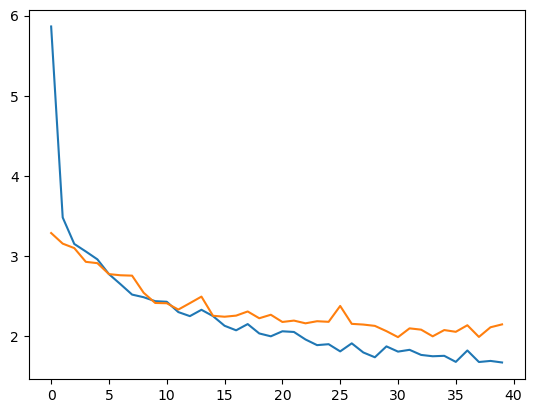

In [28]:
plt.plot(history.history["mean_squared_error"])
plt.plot(history.history["val_mean_squared_error"])

In [29]:
predictions = model.predict(X_test2)#.round(0)
r2 = r2_score(y_test2, predictions)
r2

500/500 [==============================] - 0s 856us/step


0.8478432228624153

In [30]:
hidden_size = 100
number_hidden_units1 = 128
data_rows_number = X_train.shape[0]
data_columns_number = X_train.shape[1]
inputs = Input(shape=(data_columns_number,))
layer1 = Dense(number_hidden_units1, activation = "softmax")(inputs)
dropout1 = Dropout(0.2)(layer1)  # Add dropout layer with 0.2 dropout rate
layer2 = Dense(number_hidden_units1, activation = "relu")(dropout1)
dropout2 = Dropout(0.2)(layer2)  # Add dropout layer with 0.2 dropout rate
output = Dense(1, activation="linear")(dropout2)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam",
              loss='mean_squared_error', # use this cross entropy variant
              # since the input is not one-hot encoded
              metrics=['mean_squared_error']) #We measure and print accuracy during training

history = model.fit(
    X_train_nor, y_train, epochs=40, batch_size=50, verbose=0, validation_data=(X_test2_nor, y_test2))

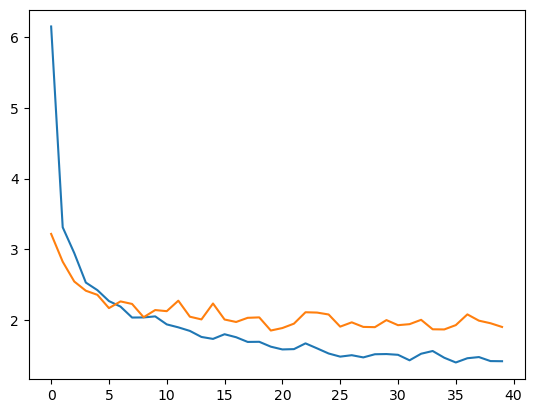

In [31]:
plt.plot(history.history["mean_squared_error"])
plt.plot(history.history["val_mean_squared_error"])

In [32]:
predictions = model.predict(X_test2_nor)#.round(0)
r2 = r2_score(y_test2, predictions)
r2

500/500 [==============================] - 0s 816us/step


0.8647794699863549

In [33]:
hidden_size = 100
number_hidden_units1 = 128
data_rows_number = X_train.shape[0]
data_columns_number = X_train.shape[1]
inputs = Input(shape=(data_columns_number,))
layer1 = Dense(number_hidden_units1, activation = "softmax")(inputs)
dropout1 = Dropout(0.2)(layer1)  # Add dropout layer with 0.2 dropout rate
layer2 = Dense(number_hidden_units1, activation = "relu")(dropout1)
dropout2 = Dropout(0.2)(layer2)  # Add dropout layer with 0.2 dropout rate
layer3 = Dense(number_hidden_units1, activation = "relu")(dropout2)
dropout3 = Dropout(0.2)(layer3)  # Add dropout layer with 0.2 dropout rate
output = Dense(1, activation="linear")(dropout3)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam",
              loss='mean_squared_error', # use this cross entropy variant
              # since the input is not one-hot encoded
              metrics=['mean_squared_error']) #We measure and print accuracy during training

history = model.fit(
    X_train, y_train, epochs=40, batch_size=50, verbose=0, validation_data=(X_test2, y_test2))


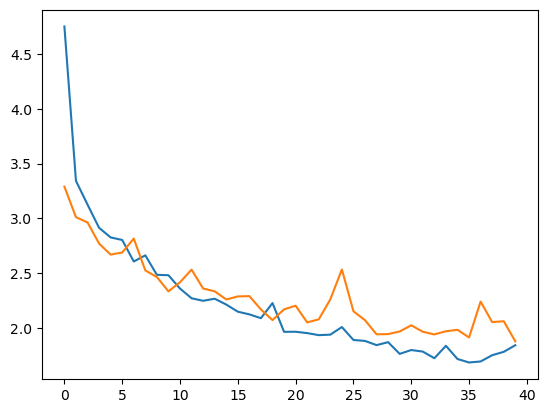

In [34]:
plt.plot(history.history["mean_squared_error"])
plt.plot(history.history["val_mean_squared_error"])

In [35]:
predictions = model.predict(X_test2)#.round(0)
r2 = r2_score(y_test2, predictions)
r2

500/500 [==============================] - 1s 1ms/step


0.8667445587494637

(-10.0, 100.0)

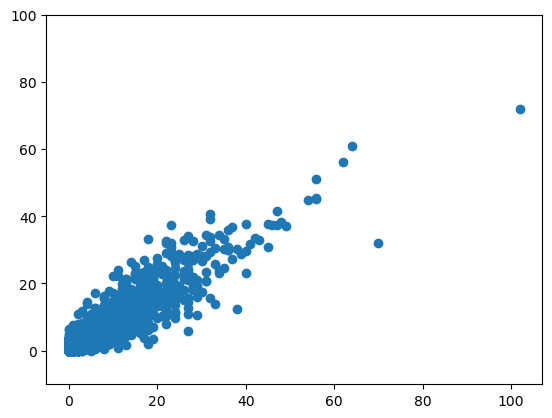

In [36]:
plt.scatter(y_test2, predictions)
plt.ylim([-10,100])

In [37]:
hidden_size = 100
number_hidden_units1 = 128
data_rows_number = X_train.shape[0]
data_columns_number = X_train.shape[1]
inputs = Input(shape=(data_columns_number,))
layer1 = Dense(number_hidden_units1, activation = "softmax")(inputs)
dropout1 = Dropout(0.2)(layer1)  # Add dropout layer with 0.2 dropout rate
layer2 = Dense(number_hidden_units1, activation = "relu")(dropout1)
dropout2 = Dropout(0.2)(layer2)  # Add dropout layer with 0.2 dropout rate
layer3 = Dense(number_hidden_units1, activation = "relu")(dropout2)
dropout3 = Dropout(0.2)(layer3)  # Add dropout layer with 0.2 dropout rate
output = Dense(1, activation="linear")(dropout3)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="Adam",
              loss='mean_squared_error', # use this cross entropy variant
              # since the input is not one-hot encoded
              metrics=['mean_squared_error']) #We measure and print accuracy during training

history = model.fit(
    X_train_nor, y_train, epochs=40, batch_size=50, verbose=0, validation_data=(X_test2_nor, y_test2))


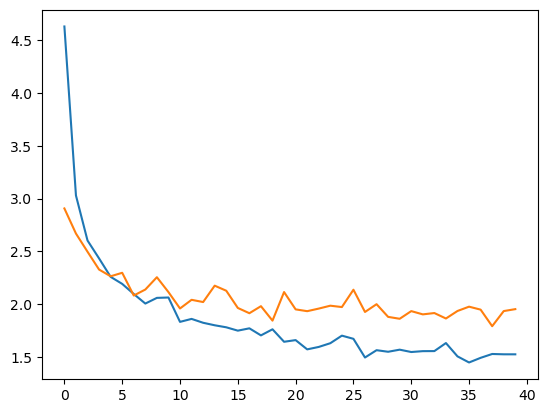

In [38]:
plt.plot(history.history["mean_squared_error"])
plt.plot(history.history["val_mean_squared_error"])

In [39]:
predictions = model.predict(X_test2_nor)#.round(0)
r2 = r2_score(y_test2, predictions)
r2

500/500 [==============================] - 0s 827us/step


0.8613282553605288

(-10.0, 100.0)

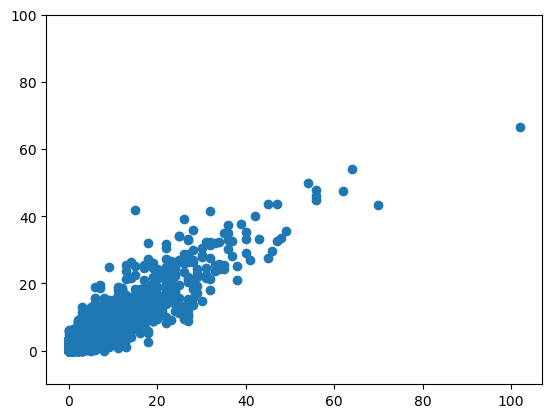

In [40]:
plt.scatter(y_test2, predictions)
plt.ylim([-10,100])